# Seven/Four Working File

In [6]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import ELU
from tensorflow.keras.activations import elu
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.python.keras import backend as k
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.io.wavfile import write
from skimage import io, data
import io as fileio
import librosa
from pydub import AudioSegment
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import spotipy
import pylast
from IPython.display import Audio
from librosa import display
from datetime import datetime
import sounddevice as sd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import soundfile as sf
from six.moves.urllib.request import urlopen
import urllib
import os, random
from time import time, sleep
%matplotlib inline

pd.set_option('display.max_colwidth', -1)

In [7]:
tf.__version__

'2.0.0-beta1'

# Data collection via Spotify, Last.FM APIs

In [8]:
"""
Code block only utilised for one-time authorisation by user on giving us access to their data, depending on scope.
"""

# from spotipy.oauth2 import SpotifyClientCredentials
# import spotipy.util as util

# cid = "" 
# secret = ""
# username = ""

# client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
# sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
# scope = 'user-library-read playlist-read-private, user-library-read, user-read-currently-playing'

# token = util.prompt_for_user_token(username, scope, cid, secret, redirect_uri="http://localhost:8888/callback/")

# if token:
#     sp = spotipy.Spotify(auth=token)
# else:
#     print("Can't get token for", username)

'\nCode block only utilised for one-time authorisation by user on giving us access to their data, depending on scope.\n'

In [42]:
# get Spotify token 

def get_spotify_service():

    cid = ""
    secret = ""
    redirectURI = "http://localhost:8888/callback/"
    username = ""
    scope = 'user-library-read, playlist-read-private, user-library-read, user-read-currently-playing'

    token = util.prompt_for_user_token(username,
                                       scope,
                                       client_id=cid,
                                       client_secret=secret,
                                       redirect_uri=redirectURI)

    service = spotipy.Spotify(auth=token)

    return service

In [43]:
# Search artist and get URI

def search_artist(artist):

    cid = "" 
    secret = ""
    username = ""

    client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    scope = 'user-library-read playlist-read-private, user-library-read, user-read-currently-playing'

    artist = str(artist)

    artist_id = sp.search(q='artist:' + artist, type='artist')
    artist_uri = artist_id['artists']['items'][0]['external_urls']['spotify'].split("/")[-1]
    
    return artist_uri

In [44]:
# Get album list via artist URI

def get_album_list(artist_uri):
    
    cid = "" 
    secret = ""
    username = ""
    
    client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    scope = 'user-library-read playlist-read-private, user-library-read, user-read-currently-playing'
    
    artist_albums = sp.artist_albums(artist_uri, album_type='album')
    album_count = len(artist_albums['items'])
    album_list_urls = []
    album_list_title = []

    for i in range(album_count):
        album_list_urls.append(artist_albums['items'][i]['external_urls']['spotify'])
        album_list_title.append(artist_albums['items'][i]['name'])

    return album_list_title, album_list_urls

In [45]:
# Get tracks of album via album URI

def album_tracks(album_uri):
    
    cid = "" 
    secret = ""
    username = ""
    
    client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    scope = 'user-library-read playlist-read-private, user-library-read, user-read-currently-playing'
    
    track_title = []
    track_url = []
    
    album_tracks = sp.album_tracks(album_uri)
    
    for i in range(len(album_tracks['items'])):
        track_title.append(album_tracks['items'][i]['name'])
        track_url.append(album_tracks['items'][i]['preview_url'])
    print(track_title)    
    return track_title, track_url

In [46]:
# End-to-end of getting track from artist input

def albums(artist):
    
    cid = "" 
    secret = ""
    username = ""
    
    client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    scope = 'user-library-read playlist-read-private, user-library-read, user-read-currently-playing'

    
    artist_uri = search_artist(artist)
    album_title, album_urls = get_album_list(artist_uri)
    print(album_title)
    choose = int(input('Please select album:\n'))
    print('You have selected: {}\n'.format(album_title[choose]))
    album_uri = album_urls[choose]
    track_list, track_url = album_tracks(album_uri)
    track_choose = int(input('Please select track:\n'))
    print("Great choice! Now playing: {}'s {}\n".format(artist.capitalize(), track_list[track_choose]))
    track_url = track_url[track_choose]
    preview_song = AudioSegment.from_mp3(fileio.BytesIO(urlopen(track_url).read()))[:10000]
    filename = artist+'_'+track_list[track_choose].lower()
    preview_song.export("/Users/alvin.tham/desktop/final/capture/tracks/{}.wav".format(filename, format="wav"))
    return filename, preview_song

In [49]:
# Getting tracks off playlist for sample collection

username = ""
playlist = 'spotify:playlist:7eEHfufKPIthOjAiDWqbkW' # Scraping data off playlist

spotify = get_spotify_service()
sp_playlist = spotify.user_playlist_tracks(username, playlist_id=playlist)
print(len(sp_playlist['items']))

   
preview_url = [sp_playlist['items'][i]['track']['preview_url'] for i in range(len(sp_playlist['items']))]
title = [sp_playlist['items'][i]['track']['name'] for i in range(len(sp_playlist['items']))]
artist = [sp_playlist['items'][i]['track']['artists'][0]['name'] for i in range(len(sp_playlist['items']))]

100


In [15]:
# Combing all data together

previews = list(zip(preview_url,title,artist)) 

In [16]:
# Random check on scraped entry

previews[5] 

(None, 'Bad Company', 'Five Finger Death Punch')

In [245]:
prevs = pd.DataFrame(previews, columns=['url', 'title', 'artist']) # Creating dataframe
prevs.dropna(axis=0, inplace=True)

In [246]:
import pylast # Logging into Last.FM to obtain each song's genre

API_KEY = ""
API_SECRET = ""
username = ""
password_hash = pylast.md5("")

network = pylast.LastFMNetwork(api_key=API_KEY, api_secret=API_SECRET,
                               username=username, password_hash=password_hash)

In [247]:
tracks = [] # Grabbing genre via Last.FM API
genres = []
artists = []

for i in previews:
    try:
        track = network.get_track(i[2], i[1])
        topItems = [topItem.item.get_name() for topItem in track.get_top_tags(limit=1)]
        tracks.append(i[1])
        if len(topItems) == 0:
            genres.append(np.NaN)
        else:
            genres.append(topItems)
        artists.append(i[2])
    except:
        tracks.append(i[1])
        genres.append(np.NaN)
        artists.append(i[2])

In [248]:
genres = list(zip(tracks, genres, artists)) # Collating new data together

In [249]:
genres_df = pd.DataFrame(genres, columns=['title1', 'genres', 'artists1']) # Creation of dataframe
df = prevs.join(genres_df['genres'])

In [251]:
df['genres'] = 'rock'
df.reset_index(drop=True, inplace=True)

In [254]:
max_count = df['genres'].value_counts().keys()[0] # Implementing genre across full dataframe via largest value count
max_count
df['genres'] = max_count

In [255]:
max_count

'rock'

In [256]:
tracklist = df['title']+'_'+df['artist']+'_'+df['genres']
tracklist = tracklist.replace({':':'', '/':'', '"':''}, regex=True)

# Conv1D Data Processing

In [17]:
# Convert wav into mel-spectros

from librosa import display

def wav_to_spectro(genre, path='/Users/alvin.tham/desktop/final/data/samples/'):
    path = path+str(genre)+"/"
    write_path = '/Users/alvin.tham/desktop/final/data/spectro/{}/'.format(genre)

    for file in os.listdir(path):
        if file[-3:] != 'wav':
            pass
        else:
            y, sr = librosa.load(path+str(file))
            D = librosa.feature.melspectrogram(y, sr=sr, n_mels=96)

            plt.figure(figsize=(12, 4))
            ax = plt.axes()
            ax.set_axis_off()
            librosa.display.specshow(librosa.power_to_db(D, ref=np.max), cmap='seismic', y_axis='mel', x_axis='time')
            plt.savefig(write_path+str(file)+'.png', bbox_inches='tight', transparent=False, pad_inches=0.0 )
            plt.close()

In [18]:
# Loading spectrograms and converting into genre-specific numpy arrays for save-down

def img_array(genre, path='/Users/alvin.tham/desktop/final/data/spectro/'):
    array_path = path+str(genre)+"/"
    array_list = []
    for file in os.listdir(array_path):
        if file[-3:] != 'png':
            pass
        else:
            img = io.imread(array_path+str(file), as_gray=True)
            array_list.append(img)
    np.save('/Users/alvin.tham/desktop/final/data/arrays/{}.npy'.format(genre), array_list)

    return array_list

In [19]:
# Loading all genre np arrays into one array, return X, y

def load_array(path='/Users/alvin.tham/desktop/final/data/arrays/'):
    
    labels = []
    final_array = []
    
    for file in os.listdir(path):
        if file[-3:] != 'npy':
            pass
        else:
            genre = file.split('.')[0]+" "
            array = np.load(path+str(file))
            for i in array:
                labels.extend(genre.split())
                final_array.extend([i])

    return np.array(final_array), labels

In [266]:
# # Convert genre wav to mel spectro to arrays

wav_to_spectro('rock')
img_array('rock')

[array([[0.06050745, 0.05570078, 0.06192118, ..., 0.03901882, 0.03110196,
         0.03986706],
        [0.19218118, 0.10484941, 0.30862353, ..., 0.05174235, 0.05174235,
         0.06983804],
        [0.19218118, 0.10484941, 0.30862353, ..., 0.05174235, 0.05174235,
         0.06983804],
        ...,
        [0.13833333, 0.12166667, 0.18833333, ..., 0.15666667, 0.15666667,
         0.15666667],
        [0.13833333, 0.12166667, 0.18833333, ..., 0.15666667, 0.15666667,
         0.15666667],
        [0.14666667, 0.13583333, 0.2       , ..., 0.21      , 0.21558824,
         0.21558824]]),
 array([[0.20673647, 0.06587961, 0.06842431, ..., 0.06276941, 0.05400431,
         0.05174235],
        [0.45417647, 0.35228941, 0.30862353, ..., 0.33773412, 0.22129176,
         0.14851529],
        [0.45417647, 0.35228941, 0.30862353, ..., 0.33773412, 0.22129176,
         0.14851529],
        ...,
        [0.14333333, 0.15333333, 0.265     , ..., 0.14333333, 0.18833333,
         0.18833333],
        [0.1

In [29]:
X, y = load_array()

In [30]:
encoder = LabelEncoder()
y  = encoder.fit_transform(y)

In [31]:
encoder.classes_

array(['classical', 'dance', 'electronica', 'pop', 'rnb', 'rock',
       'shoegazeanddreampop'], dtype='<U19')

In [32]:
genre_count = pd.DataFrame(np.unique(y, return_counts=True)).drop(0)
genre_count.columns = encoder.classes_
genre_count = genre_count.T.sort_values(1, ascending=False)
genre_count

,1
pop,302
dance,286
rnb,250
rock,249
classical,218
shoegazeanddreampop,197
electronica,194


In [33]:
y_cat = to_categorical(y)
y_cat.shape

(1696, 7)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3, shuffle=True, stratify=y_cat)

In [35]:
X_train.shape

(1187, 217, 669)

# Conv1D model

In [21]:
"""
0.69155

cnn_model.load_weights('0.69155_best_weights_20190814-113625.hdf5')

"""

conv1d_input_shape = (217, 669)
num_classes = 7
batch_size = 32
epoch_count = 30
L2_regularization = 0.01

cnn_model = Sequential()
cnn_model.add(Conv1D(300, kernel_size=1, padding='same', strides=2, kernel_regularizer=regularizers.l2(0.01), input_shape=conv1d_input_shape))
cnn_model.add(ELU(alpha=1.5))
cnn_model.add(BatchNormalization(momentum=0.9))
cnn_model.add(MaxPooling1D(pool_size=3))
cnn_model.add(Dropout(0.4))

cnn_model.add(Conv1D(150, kernel_size=1, strides=1, kernel_regularizer=regularizers.l2(0.01), padding='same'))
cnn_model.add(ELU(alpha=1.5))
cnn_model.add(BatchNormalization(momentum=0.9))
cnn_model.add(Dropout(0.4))

cnn_model.add(Conv1D(50, kernel_size=1, strides=1, kernel_regularizer=regularizers.l2(0.01), padding='same'))
cnn_model.add(ELU(alpha=1.5))
cnn_model.add(BatchNormalization(momentum=0.9))
cnn_model.add(MaxPooling1D(pool_size=1))
cnn_model.add(Dropout(0.4))

cnn_model.add(Flatten())

cnn_model.add(Dense(100)) 
cnn_model.add(ELU(alpha=1.5))
cnn_model.add(Dropout(0.4))

cnn_model.add(Dense(num_classes,activation='softmax'))

cnn_model.compile(loss='categorical_crossentropy' , optimizer='sgd' , metrics=['categorical_accuracy'])

tensorboard = TensorBoard(log_dir='my_log_dir/{}'.format(datetime.now().strftime("%Y%m%d-%H%M%S")))


checkpointer = ModelCheckpoint(filepath="best_weights_{}.hdf5".format(datetime.now().strftime("%Y%m%d-%H%M%S")), 
                               monitor = 'val_categorical_accuracy',
                               verbose=1, 
                               save_best_only=True)

callbacks = [tensorboard, checkpointer]

print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 109, 300)          201000    
_________________________________________________________________
elu_4 (ELU)                  (None, 109, 300)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 109, 300)          1200      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 36, 300)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 36, 300)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 36, 150)           45150     
_________________________________________________________________
elu_5 (ELU)                  (None, 36, 150)          

In [16]:
cnn_model.fit(X_train, y_train, batch_size=batch_size, epochs=epoch_count, verbose=2, validation_data=(X_test, y_test), callbacks=callbacks)
   
y_true = np.argmax(y_test, axis=1)
y_pred = cnn_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6]
target_names = encoder.classes_

print(y_test.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

In [30]:
cnn_model.save('cnn_model.h5')

In [101]:
tf.saved_model.save(cnn_model, "savedmodel")

# Sample Recommender (Freesound API)

In [22]:
def previews(search):
    
    search = str(search)
    preview_ids = []
    preview_urls = []
    
    r = requests.get("https://freesound.org/apiv2/search/text/?query={}&token=4GqIhwqd8DhNYeNM7r0SWp4kvEXrKDOe3ZACyifu".format(search))
    results = r.json()['results']

    for i in range(len(results)):
        preview_ids.append(results[i]['id'])
    
    for i in preview_ids:
        preview_urls.append(requests.get('https://freesound.org/apiv2/sounds/{}/?token=4GqIhwqd8DhNYeNM7r0SWp4kvEXrKDOe3ZACyifu'.format(i)).json()['previews']['preview-hq-mp3'])

    return preview_urls

In [23]:
tags = {
    'shoegazeanddreampop': ('guitar loop', 'drone'),
    'dance': ('trance loop', 'house loop', 'techno loop', 'tech house loop', 'dance loop', 'dubstep loop'),
    'classical': ('violin', 'piano', 'orchestra', 'concert band', 'woodwinds', 'strings'),
    'electronica': ('lofi', 'chillhop', 'synthwave', 'electronic'),
    'rnb': ('hiphop', 'r&b'),
    'pop': ('pop loop', 'pop vocals'),
    'rock': ('rock loop', 'rock loop')
}

# Conv1D Load Model

In [24]:
cnn_model = keras.models.load_model('cnn_model.h5')
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 109, 300)          201000    
_________________________________________________________________
elu (ELU)                    (None, 109, 300)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 109, 300)          1200      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 36, 300)           0         
_________________________________________________________________
dropout (Dropout)            (None, 36, 300)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 36, 150)           45150     
_________________________________________________________________
elu_1 (ELU)                  (None, 36, 150)           0

In [25]:
"""
Pure running of model without Spotify track selection

"""

def run_cnn_pure(url, duration=5, fs=22050, channels=2):
    predict_song = sd.rec(int(duration * fs), samplerate=fs, channels=channels) # Recording 10s samples
    sd.wait()
    write('/Users/alvin.tham/desktop/final/data/samples/test/predict_song.wav', fs, predict_song)

    y, sr = librosa.load('/Users/alvin.tham/desktop/final/data/samples/test/predict_song.wav')
    D = librosa.feature.melspectrogram(y, sr=sr, n_mels=96)
        
    plt.figure(figsize=(12, 4))
    ax = plt.axes()
    ax.set_axis_off()
    librosa.display.specshow(librosa.power_to_db(D, ref=np.max), cmap='seismic', y_axis='mel', x_axis='time')
    plt.savefig('/Users/alvin.tham/desktop/final/data/samples/test/predict_song.wav'+'.png', bbox_inches='tight', transparent=False, pad_inches=0.0 )
    plt.close()
    img = io.imread('/Users/alvin.tham/desktop/final/data/samples/test/predict_song.wav.png', as_gray=True)
    img = img.reshape(1, img.shape[0], img.shape[1])
    cnn_test_result = cnn_model.predict(img)
    cnn_pd = pd.DataFrame(cnn_test_result)
    cnn_pd.columns = ['classical', 'dance', 'electronica', 'pop', 'rnb', 'rock', 'shoegazeanddreampop']
    plt.figure(figsize=(8,4))
    sns.barplot(x=crnn_pd.columns, y=crnn_pd.iloc[0,:])    
    song_list = random_songs(cnn_pd.T.sort_values(0, ascending=False).index[0])
    return cnn_pd.T.sort_values(0, ascending=False).index[0] #, song_list

In [26]:
"""
Full function of Spotify selection and running of model

"""

def run_cnn_model(artist, duration=5, fs=22050, channels=2):
    filename, predict_song = albums(artist)
    y, sr = librosa.load('./capture/tracks/{}.wav'.format(filename))
    D = librosa.feature.melspectrogram(y, sr=sr, n_mels=96)
        
    plt.figure(figsize=(12, 4))
    ax = plt.axes()
    ax.set_axis_off()
    librosa.display.specshow(librosa.power_to_db(D, ref=np.max), cmap='seismic', y_axis='mel', x_axis='time')
    plt.savefig('./capture/spectros/{}.wav'.format(filename)+'.png', bbox_inches='tight', transparent=False, pad_inches=0.0 )
    plt.close()
    img = io.imread('./capture/spectros/{}.wav.png'.format(filename), as_gray=True)
    img = img.reshape(1, img.shape[0], img.shape[1])
    cnn_test_result = cnn_model.predict(img)
    cnn_pd = pd.DataFrame(cnn_test_result)
    cnn_pd.columns = ['classical', 'dance', 'electronica', 'pop', 'rnb', 'rock', 'shoegazeanddreampop']
    plt.figure(figsize=(10,4))
    sns.barplot(x=cnn_pd.columns, y=cnn_pd.iloc[0,:])
    genre = cnn_pd.T.sort_values(0, ascending=False).index[0]
    print(genre)
    
    search = str(np.random.choice(tags[genre]))
    preview_ids = []
    preview_urls = []
    r = requests.get("https://freesound.org/apiv2/search/text/?query={}&token=4GqIhwqd8DhNYeNM7r0SWp4kvEXrKDOe3ZACyifu".format(search))
    results = r.json()['results']

    for i in range(len(results)):
        preview_ids.append(results[i]['id'])
    
    for i in preview_ids:
        preview_urls.append(requests.get('https://freesound.org/apiv2/sounds/{}/?token=4GqIhwqd8DhNYeNM7r0SWp4kvEXrKDOe3ZACyifu'.format(i)).json()['previews']['preview-hq-mp3'])

    return preview_urls

# Model Run

In [30]:
### Load model weights if needed

# cnn_model.load_weights('0.69155_best_weights_20190814-113625.hdf5')

['The Getaway', "I'm with You", 'Stadium Arcadium', 'By the Way', 'By the Way (Deluxe Edition)', 'Californication', 'Californication (Deluxe Edition)', 'One Hot Minute (Deluxe Edition)', 'One Hot Minute', 'Blood Sugar Sex Magik (Deluxe Edition)', 'Blood Sugar Sex Magik', "Mother's Milk", 'The Uplift Mofo Party Plan', 'Freaky Styley', 'Red Hot Chili Peppers']
Please select album:
5
You have selected: Californication

['Around the World', 'Parallel Universe', 'Scar Tissue', 'Otherside', 'Get on Top', 'Californication', 'Easily', 'Porcelain', 'Emit Remmus', 'I Like Dirt', 'This Velvet Glove', 'Savior', 'Purple Stain', 'Right on Time', "Road Trippin'"]
Please select track:
5
Great choice! Now playing: Red hot chilli peppers's Californication

rock


['https://freesound.org/data/previews/432/432149_8713024-hq.mp3',
 'https://freesound.org/data/previews/432/432148_8713024-hq.mp3',
 'https://freesound.org/data/previews/101/101121_1657645-hq.mp3',
 'https://freesound.org/data/previews/423/423269_404624-hq.mp3',
 'https://freesound.org/data/previews/475/475657_2866779-hq.mp3',
 'https://freesound.org/data/previews/477/477475_7785430-hq.mp3',
 'https://freesound.org/data/previews/66/66956_649468-hq.mp3',
 'https://freesound.org/data/previews/256/256256_233371-hq.mp3',
 'https://freesound.org/data/previews/171/171167_3162775-hq.mp3',
 'https://freesound.org/data/previews/432/432150_8713024-hq.mp3',
 'https://freesound.org/data/previews/432/432264_8713024-hq.mp3',
 'https://freesound.org/data/previews/470/470766_5873027-hq.mp3',
 'https://freesound.org/data/previews/423/423278_404624-hq.mp3',
 'https://freesound.org/data/previews/37/37867_382028-hq.mp3',
 'https://freesound.org/data/previews/331/331876_5829171-hq.mp3']

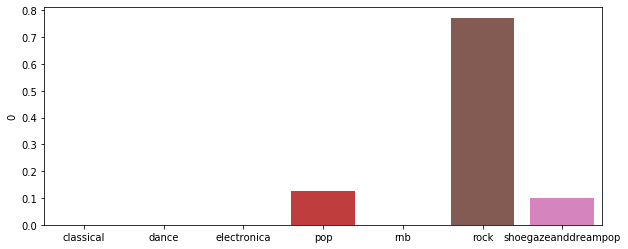

In [48]:
run_cnn_model('red hot chilli peppers')

# Model Weights Retention

### 0.6421

In [354]:
"""
0.6421

 precision    recall  f1-score   support

          classical       0.84      0.92      0.88        74
              dance       0.57      0.62      0.59       125
        electronica       0.49      0.44      0.46        64
                pop       0.61      0.50      0.55       119
                rnb       0.58      0.59      0.59       116
               rock       0.73      0.80      0.77        96
shoegazeanddreampop       0.69      0.67      0.68        85

          micro avg       0.64      0.64      0.64       679
          macro avg       0.64      0.65      0.65       679
       weighted avg       0.64      0.64      0.64       679
       
crnn_model.load_weights('0.6421_best_weights_20190813-145940.hdf5')

"""

# conv1d_input_shape = (217, 669)
# num_classes = 7
# batch_size = 32
# epoch_count = 30
# L2_regularization = 0.1

# crnn_model = Sequential()
# crnn_model.add(Conv1D(300, kernel_size=1, padding='same', 
#                       activation='tanh', strides=2, kernel_regularizer=regularizers.l2(0.01), input_shape=conv1d_input_shape))
# crnn_model.add(BatchNormalization(momentum=0.9))
# crnn_model.add(MaxPooling1D(pool_size=3)) 

# crnn_model.add(Conv1D(150, kernel_size=1, strides=1, activation='selu', padding='same'))
# crnn_model.add(BatchNormalization(momentum=0.9))
# # crnn_model.add(MaxPooling1D(pool_size=3, strides=2)) 

# crnn_model.add(Conv1D(150, kernel_size=1, strides=1, activation='selu', padding='same'))
# crnn_model.add(BatchNormalization(momentum=0.9))
# # crnn_model.add(MaxPooling1D(pool_size=3, strides=2)) 

# # crnn_model.add(Dropout(0.5))
# # crnn_model.add(LSTM(64, return_sequences=True))

# crnn_model.add(Dropout(0.5))
# crnn_model.add(Flatten())

# crnn_model.add(Dense(50, activation='selu')) 
# crnn_model.add(Dropout(0.5))

# crnn_model.add(Dense(num_classes,activation='softmax'))

# crnn_model.compile(loss='categorical_crossentropy' , optimizer='sgd' , metrics=['categorical_accuracy'])

# tensorboard = TensorBoard(log_dir='my_log_dir/{}'.format(datetime.now().strftime("%Y%m%d-%H%M%S")))


# checkpointer = ModelCheckpoint(filepath="best_weights_{}.hdf5".format(datetime.now().strftime("%Y%m%d-%H%M%S")), 
#                                monitor = 'val_categorical_accuracy',
#                                verbose=1, 
#                                save_best_only=True)

# callbacks = [tensorboard, checkpointer]

# print(crnn_model.summary())

"\n0.6421\n\n precision    recall  f1-score   support\n\n          classical       0.84      0.92      0.88        74\n              dance       0.57      0.62      0.59       125\n        electronica       0.49      0.44      0.46        64\n                pop       0.61      0.50      0.55       119\n                rnb       0.58      0.59      0.59       116\n               rock       0.73      0.80      0.77        96\nshoegazeanddreampop       0.69      0.67      0.68        85\n\n          micro avg       0.64      0.64      0.64       679\n          macro avg       0.64      0.65      0.65       679\n       weighted avg       0.64      0.64      0.64       679\n       \ncrnn_model.load_weights('0.6421_best_weights_20190813-145940.hdf5')\n\n"

### 0.65422

In [386]:
"""

crnn_model.load_weights('0.65422_best_weights_20190813-162013.hdf5')
"""

# conv1d_input_shape = (217, 669)
# num_classes = 7
# batch_size = 32
# epoch_count = 30
# L2_regularization = 0.01

# crnn_model = Sequential()
# crnn_model.add(Conv1D(300, kernel_size=1, padding='same', 
#                       activation='elu', strides=2, kernel_regularizer=regularizers.l2(0.01), input_shape=conv1d_input_shape))
# crnn_model.add(BatchNormalization(momentum=0.9))
# crnn_model.add(MaxPooling1D(pool_size=3))
# crnn_model.add(Dropout(0.4))

# crnn_model.add(Conv1D(150, kernel_size=1, strides=1, kernel_regularizer=regularizers.l2(0.01), activation='elu', padding='same'))
# crnn_model.add(BatchNormalization(momentum=0.9))
# crnn_model.add(Dropout(0.4))
# # crnn_model.add(MaxPooling1D(pool_size=3, strides=3))  

# crnn_model.add(Conv1D(50, kernel_size=1, strides=1, kernel_regularizer=regularizers.l2(0.01), activation='elu', padding='same'))
# crnn_model.add(BatchNormalization(momentum=0.9))
# crnn_model.add(MaxPooling1D(pool_size=3))
# crnn_model.add(Dropout(0.4))

# crnn_model.add(Flatten())

# crnn_model.add(Dense(100, activation='elu')) 
# crnn_model.add(Dropout(0.4))

# crnn_model.add(Dense(num_classes,activation='softmax'))

# crnn_model.compile(loss='categorical_crossentropy' , optimizer='sgd' , metrics=['categorical_accuracy'])

# tensorboard = TensorBoard(log_dir='my_log_dir/{}'.format(datetime.now().strftime("%Y%m%d-%H%M%S")))


# checkpointer = ModelCheckpoint(filepath="best_weights_{}.hdf5".format(datetime.now().strftime("%Y%m%d-%H%M%S")), 
#                                monitor = 'val_categorical_accuracy',
#                                verbose=1, 
#                                save_best_only=True)

# callbacks = [tensorboard, checkpointer]

# print(crnn_model.summary())

"\n\ncrnn_model.load_weights('0.65422_best_weights_20190813-162013.hdf5')\n"

## 0.66601

In [470]:
"""

0.66601

                       precision    recall  f1-score   support

          classical       0.86      0.85      0.85        65
              dance       00        86
        electronica       0.42      0.55      0.48        58
                pop       0.63      0.52      0.57        91
                rnb       0.80      0.43      0.56        75
               rock       0.85      0.63      0.72        75
shoegazeanddreampop       0.44      0.88      0.59        59

          micro avg       0.62      0.62      0.62       509
          macro avg       0.66      0.64      0.63       509
       weighted avg       0.67      0.62      0.63       509


crnn_model.load_weights('0.66601_best_weights_20190814-111413.hdf5')


"""

# conv1d_input_shape = (217, 669)
# num_classes = 7
# batch_size = 32
# epoch_count = 30
# L2_regularization = 0.01

# crnn_model = Sequential()
# crnn_model.add(Conv1D(300, kernel_size=1, padding='same', 
#                       activation='elu', strides=2, kernel_regularizer=regularizers.l2(0.01), input_shape=conv1d_input_shape))
# crnn_model.add(BatchNormalization(momentum=0.9))
# crnn_model.add(MaxPooling1D(pool_size=3))
# crnn_model.add(Dropout(0.4))

# crnn_model.add(Conv1D(150, kernel_size=1, strides=1, kernel_regularizer=regularizers.l2(0.01), activation='elu', padding='same'))
# crnn_model.add(BatchNormalization(momentum=0.9))
# crnn_model.add(Dropout(0.4))
# # crnn_model.add(MaxPooling1D(pool_size=3, strides=3))  

# crnn_model.add(Conv1D(50, kernel_size=1, strides=1, kernel_regularizer=regularizers.l2(0.01), activation='elu', padding='same'))
# crnn_model.add(BatchNormalization(momentum=0.9))
# crnn_model.add(MaxPooling1D(pool_size=1))
# crnn_model.add(Dropout(0.4))

# crnn_model.add(Flatten())

# crnn_model.add(Dense(100, activation='elu')) 
# crnn_model.add(Dropout(0.4))

# crnn_model.add(Dense(num_classes,activation='softmax'))

# crnn_model.compile(loss='categorical_crossentropy' , optimizer='sgd' , metrics=['categorical_accuracy'])

# tensorboard = TensorBoard(log_dir='my_log_dir/{}'.format(datetime.now().strftime("%Y%m%d-%H%M%S")))


# checkpointer = ModelCheckpoint(filepath="best_weights_{}.hdf5".format(datetime.now().strftime("%Y%m%d-%H%M%S")), 
#                                monitor = 'val_categorical_accuracy',
#                                verbose=1, 
#                                save_best_only=True)

# callbacks = [tensorboard, checkpointer]

# print(crnn_model.summary())

"\n\n0.66601\n\n           precision    recall  f1-score   support\n\n          classical       0.86      0.85      0.85        65\n              dance       0.65      0.62      0.63        86\n        electronica       0.42      0.55      0.48        58\n                pop       0.63      0.52      0.57        91\n                rnb       0.80      0.43      0.56        75\n               rock       0.85      0.63      0.72        75\nshoegazeanddreampop       0.44      0.88      0.59        59\n\n          micro avg       0.62      0.62      0.62       509\n          macro avg       0.66      0.64      0.63       509\n       weighted avg       0.67      0.62      0.63       509\n\n\ncrnn_model.load_weights('0.66601_best_weights_20190814-111413.hdf5')\n\n\n"

## 0.69155

In [493]:
"""
0.69155

crnn_model.load_weights('0.69155_best_weights_20190814-113625.hdf5')

"""

# conv1d_input_shape = (217, 669)
# num_classes = 7
# batch_size = 32
# epoch_count = 30
# L2_regularization = 0.01

# crnn_model = Sequential()
# crnn_model.add(Conv1D(300, kernel_size=1, padding='same', strides=2, kernel_regularizer=regularizers.l2(0.01), input_shape=conv1d_input_shape))
# crnn_model.add(ELU(alpha=1.5))
# crnn_model.add(BatchNormalization(momentum=0.9))
# crnn_model.add(MaxPooling1D(pool_size=3))
# crnn_model.add(Dropout(0.4))

# crnn_model.add(Conv1D(150, kernel_size=1, strides=1, kernel_regularizer=regularizers.l2(0.01), padding='same'))
# crnn_model.add(ELU(alpha=1.5))
# crnn_model.add(BatchNormalization(momentum=0.9))
# crnn_model.add(Dropout(0.4))
# # crnn_model.add(MaxPooling1D(pool_size=3, strides=3))  

# crnn_model.add(Conv1D(50, kernel_size=1, strides=1, kernel_regularizer=regularizers.l2(0.01), padding='same'))
# crnn_model.add(ELU(alpha=1.5))
# crnn_model.add(BatchNormalization(momentum=0.9))
# crnn_model.add(MaxPooling1D(pool_size=1))
# crnn_model.add(Dropout(0.4))

# crnn_model.add(Flatten())

# crnn_model.add(Dense(100)) 
# crnn_model.add(ELU(alpha=1.5))
# crnn_model.add(Dropout(0.4))

# crnn_model.add(Dense(num_classes,activation='softmax'))

# crnn_model.compile(loss='categorical_crossentropy' , optimizer='sgd' , metrics=['categorical_accuracy'])

# tensorboard = TensorBoard(log_dir='my_log_dir/{}'.format(datetime.now().strftime("%Y%m%d-%H%M%S")))


# checkpointer = ModelCheckpoint(filepath="best_weights_{}.hdf5".format(datetime.now().strftime("%Y%m%d-%H%M%S")), 
#                                monitor = 'val_categorical_accuracy',
#                                verbose=1, 
#                                save_best_only=True)

# callbacks = [tensorboard, checkpointer]

# print(crnn_model.summary())

"\n0.69155\n\ncrnn_model.load_weights('0.69155_best_weights_20190814-113625.hdf5')\n\n"